In [246]:
# imports
import os
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
import optax
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from nilearn import plotting, datasets
from tqdm import tqdm
import pandas as pd
from pycocotools.coco import COCO
import ast
import random
from jax import tree_util


In [159]:
plt.style.use('dark_background')
plt.rcParams['font.family'] = 'Times New Roman'
make_coco_metas = False

In [160]:
ROOT_DIR = '/Users/syrkis/virian/projects/algonauts/'
DATA_DIR = os.path.join(ROOT_DIR, 'data')
COCO_PATH = os.path.join(DATA_DIR, 'nsd_stim_info_merged.csv')
ANNOT_PATH = os.path.join(DATA_DIR, 'annotations')

In [208]:
IMAGE_DIM = 128  # for resizing images

## coco

In [162]:
TRAIN_CAT_FILE = os.path.join(ANNOT_PATH, 'instances_train2017.json')
VAL_CAT_FILE = os.path.join(ANNOT_PATH, 'instances_val2017.json')
TRAIN_CAP_FILE = os.path.join(ANNOT_PATH, 'captions_train2017.json')
VAL_CAP_FILE = os.path.join(ANNOT_PATH, 'captions_val2017.json')

In [163]:

def extract_meta(captions_coco, instances_coco, merged_anns, nds_coco_img_ids):
    valid_ids = set(instances_coco.getImgIds())
    for img_id in tqdm(valid_ids):
        anns = captions_coco.loadAnns(captions_coco.getAnnIds(imgIds=img_id))
        captions = [ann['caption'] for ann in anns]
        innstances = instances_coco.loadAnns(instances_coco.getAnnIds(imgIds=img_id))
        categories = list(set([instance['category_id'] for instance in innstances]))
        supercategory = [entry['supercategory'] for entry in instances_coco.loadCats(categories)]
        merged_anns.append({ 'cocoId': img_id, 'captions': captions, 'categories': categories, 'supercategory': supercategory })
    return merged_anns


In [164]:
if make_coco_metas:
    train_instances_coco = COCO(TRAIN_CAT_FILE)
    val_instances_coco = COCO(VAL_CAT_FILE)
    train_captions_coco = COCO(TRAIN_CAP_FILE)
    val_captions_coco = COCO(VAL_CAP_FILE)

    merged_anns = []
    nsd_coco = pd.read_csv(COCO_PATH)
    nsd_coco_img_ids = set(nsd_coco['cocoId'])

    valid_ids = set(val_instances_coco.getImgIds()).intersection(nsd_coco_img_ids)
    merged_anns = extract_meta(val_captions_coco, val_instances_coco, merged_anns, nsd_coco_img_ids)
    merged_anns = extract_meta(train_captions_coco, train_instances_coco, merged_anns, nsd_coco_img_ids)
    df = pd.DataFrame(merged_anns)
    df.to_csv(os.path.join(DATA_DIR, 'coco_meta_data.csv'), index=False)
    
    del train_instances_coco, val_instances_coco, train_captions_coco, val_captions_coco, merged_anns, nsd_coco, df

In [165]:
coco_df = pd.read_csv(os.path.join(DATA_DIR, 'coco_meta_data.csv'), index_col='cocoId')
coco_df['categories'] = coco_df['categories'].apply(lambda x: ast.literal_eval(x))
coco_df['supercategory'] = coco_df['supercategory'].apply(lambda x: ast.literal_eval(x))
coco_df['captions'] = coco_df['captions'].apply(lambda x: ast.literal_eval(x))
nsd_df = pd.read_csv(os.path.join(DATA_DIR, 'nsd_stim_info_merged.csv'))
meta_data = coco_df.loc[nsd_df['cocoId']]

Exception ignored in: <function _xla_gc_callback at 0x7fbe447f8af0>
Traceback (most recent call last):
  File "/Users/syrkis/miniconda3/lib/python3.10/site-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


In [ ]:
coco = COCO(VAL_CAT_FILE)
cats = coco.loadCats(coco.getCatIds())
cat_id_to_name = {cat['id']: cat['name'] for cat in cats}
cat_name_to_id = {cat['name']: cat['id'] for cat in cats}

loading annotations into memory...
Done (t=1.00s)
creating index...
index created!


In [ ]:
cat_id_to_name

{1: 'person',
 2: 'bicycle',
 3: 'car',
 4: 'motorcycle',
 5: 'airplane',
 6: 'bus',
 7: 'train',
 8: 'truck',
 9: 'boat',
 10: 'traffic light',
 11: 'fire hydrant',
 13: 'stop sign',
 14: 'parking meter',
 15: 'bench',
 16: 'bird',
 17: 'cat',
 18: 'dog',
 19: 'horse',
 20: 'sheep',
 21: 'cow',
 22: 'elephant',
 23: 'bear',
 24: 'zebra',
 25: 'giraffe',
 27: 'backpack',
 28: 'umbrella',
 31: 'handbag',
 32: 'tie',
 33: 'suitcase',
 34: 'frisbee',
 35: 'skis',
 36: 'snowboard',
 37: 'sports ball',
 38: 'kite',
 39: 'baseball bat',
 40: 'baseball glove',
 41: 'skateboard',
 42: 'surfboard',
 43: 'tennis racket',
 44: 'bottle',
 46: 'wine glass',
 47: 'cup',
 48: 'fork',
 49: 'knife',
 50: 'spoon',
 51: 'bowl',
 52: 'banana',
 53: 'apple',
 54: 'sandwich',
 55: 'orange',
 56: 'broccoli',
 57: 'carrot',
 58: 'hot dog',
 59: 'pizza',
 60: 'donut',
 61: 'cake',
 62: 'chair',
 63: 'couch',
 64: 'potted plant',
 65: 'bed',
 67: 'dining table',
 70: 'toilet',
 72: 'tv',
 73: 'laptop',
 74: 'mo

## data

In [ ]:
# get nsd files for particular subject
def get_files(subject, split='training'):
    if split == 'training':
        lh_fmri_file = os.path.join(DATA_DIR, subject, 'training_split/training_fmri/lh_training_fmri.npy')
        rh_fmri_file = os.path.join(DATA_DIR, subject, 'training_split/training_fmri/rh_training_fmri.npy')
    image_dir = os.path.join(DATA_DIR, subject, split + '_split', split + '_images')
    image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.png')]
    return lh_fmri_file, rh_fmri_file, image_files

In [ ]:
def preprocess(image):
    image = image.resize((IMAGE_DIM, IMAGE_DIM))
    image = np.array(image)
    image = image / 255.0
    image = image.astype(np.float32)
    return image

In [257]:
# get batch for subject. TODO: make subject mixed batches. fmri dimensions might be subject specific.
def get_subject_batches(subject, batch_size, n=None):
    n = n if n else len(image_files)
    _, _, image_files = get_files(subject)
    # lh, rh = np.load(lh_file), np.load(rh_file)
    image_files = image_files[:n]
    images = []
    # look up categories for each image
    coco_ids = [int(f.split('.')[0].split('-')[-1]) for f in image_files]
    categories = meta_data.iloc[coco_ids]['categories'].values
    supers = meta_data.iloc[coco_ids]['supercategory'].values
    captions = meta_data.iloc[coco_ids]['captions'].values
    for image_file in tqdm(image_files):
        images.append(np.array(preprocess(Image.open(image_file))))
    images = jnp.array(images)
    while True:
        perm = np.random.permutation(len(image_files))
        for i in range(0, len(image_files), batch_size):
            idxs = perm[i:i + batch_size]
            # sample random category from each category list
            cat = jnp.array([np.random.choice(cat) for cat in categories[idxs]])
            yield images[idxs], cat, supers[idxs], captions[idxs]

In [258]:
loader = get_subject_batches('subj05', 16, n=100)
image, cats, supers, caps = next(loader)

100%|██████████| 100/100 [00:01<00:00, 53.41it/s]


In [263]:
cats

Array([64,  7, 22, 16, 17, 13, 64, 40,  7,  1, 15, 47, 65, 35, 72, 18],      dtype=int32)

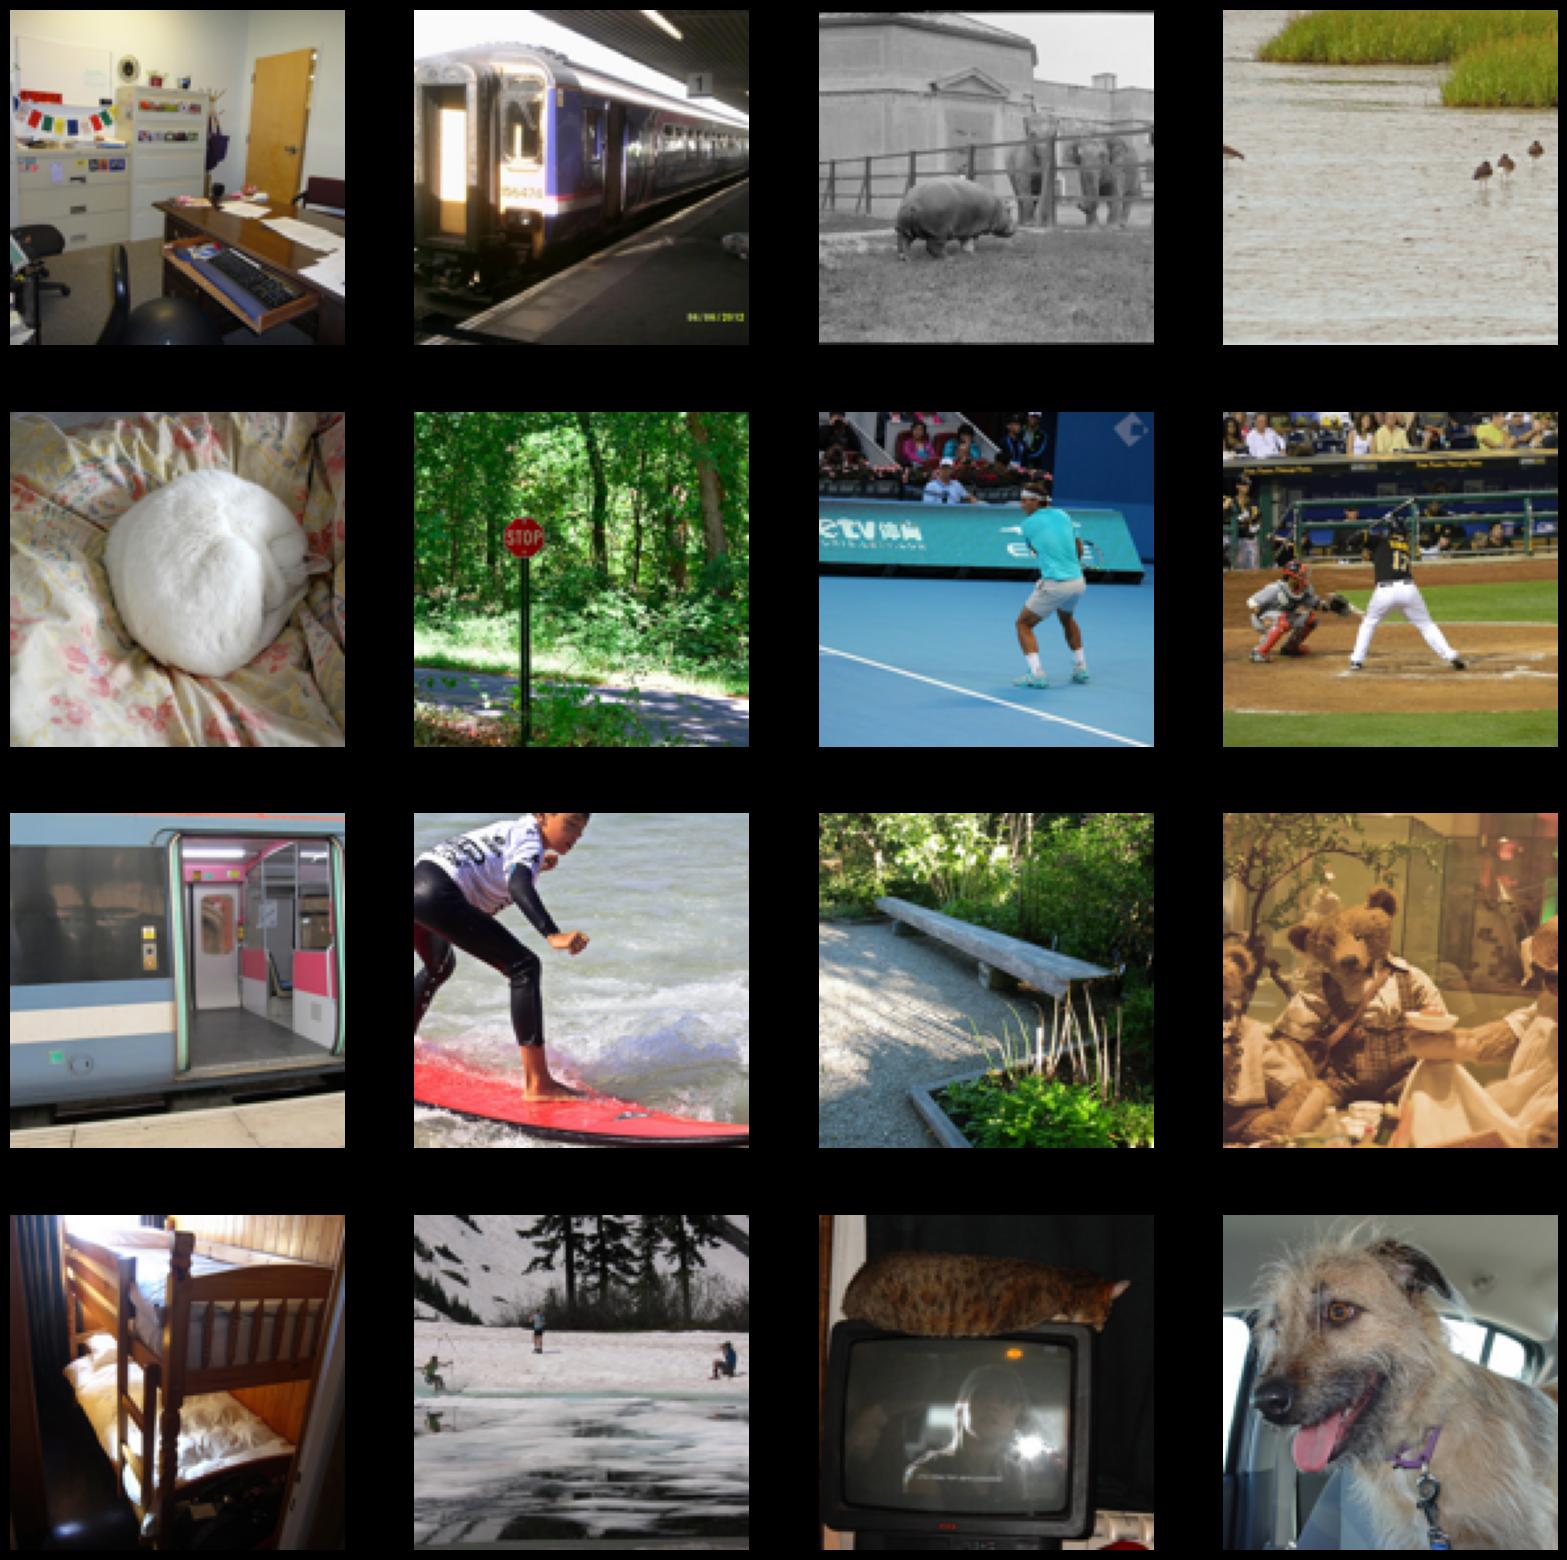

In [261]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20), dpi=100)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(image[i])
    ax.axis('off')
plt.show()

## model

In [272]:
# init params
def init_mlp(layer_sizes, rng):
    params = []
    for n_in, n_out in zip(layer_sizes[:-1], layer_sizes[1:]):
        w = jax.random.normal(rng, (n_in, n_out)) * jnp.sqrt(2 / n_in)
        b = jax.random.normal(rng, (n_out,)) * jnp.sqrt(2 / n_in)
        params.append((w, b))
    return params

def relu(x):
    return jnp.maximum(0, x)

def predict_mlp(params, x):
    activations = x
    for w, b in params:
        outputs = jnp.dot(activations, w) + b
        activations = relu(outputs)
    return jax.nn.sigmoid(outputs)

def loss_fn(params, x, y):
    pred = predict_mlp(params, x)  # batch_size x image_dim
    return -jnp.mean(y * jnp.log(pred) + (1 - y) * jnp.log(1 - pred))

## training

In [273]:
rng = jax.random.PRNGKey(0)